<a href="https://colab.research.google.com/github/RuchiV78/MelanomaDetection/blob/main/RuchiVarma_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin_cancer/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin_cancer/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize one instance of all the nine classes present in the dataset

In [12]:
import matplotlib.pyplot as plt

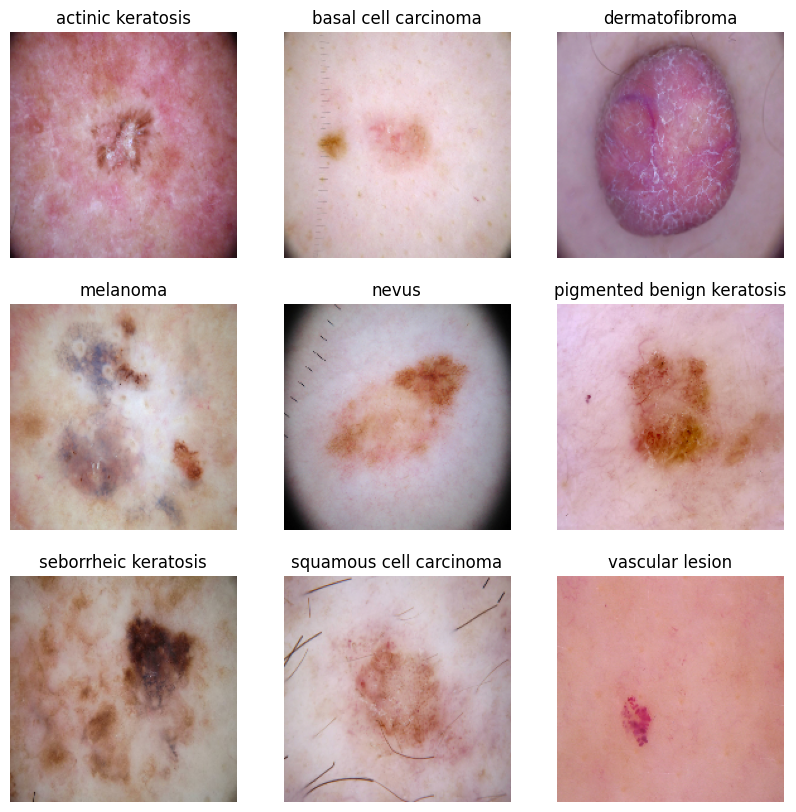

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
   filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))

   for image, label in filtered_ds.take(1):
       ax = plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(class_names[label.numpy()[0]])
       plt.axis('off')


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [10]:
#RV code
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
"""
model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
"""
#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 5
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',
 #             optimizer='sgd',
  #            metrics=['accuracy'])

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                        

In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "/content/gdrive/My Drive/Skin_cancer/Train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks=[cp_callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - ETA: 0s - loss: 6.7291 - accuracy: 0.3394
Epoch 1: saving model to /content/gdrive/My Drive/Skin_cancer/Train/cp.ckpt
169/169 [==============================] - 2036s 9s/step - loss: 6.7291 - accuracy: 0.3394 - val_loss: 5.9099 - val_accuracy: 0.0870
Epoch 2/20
132/169 [======================>.......] - ETA: 5:04 - loss: 3.8989 - accuracy: 0.4510

**Visualizing training results**

In [2]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: ignored

## **Observation**
It is clearly indicated that the Model is overfitting.. There is a big variation in the Training and Validation Accuracy. Also with the number of iterations of training - the training loss decreases but the same pattern isnt visible in the Validation loss.


## **Data Augmentation**

In [17]:
data_augment = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

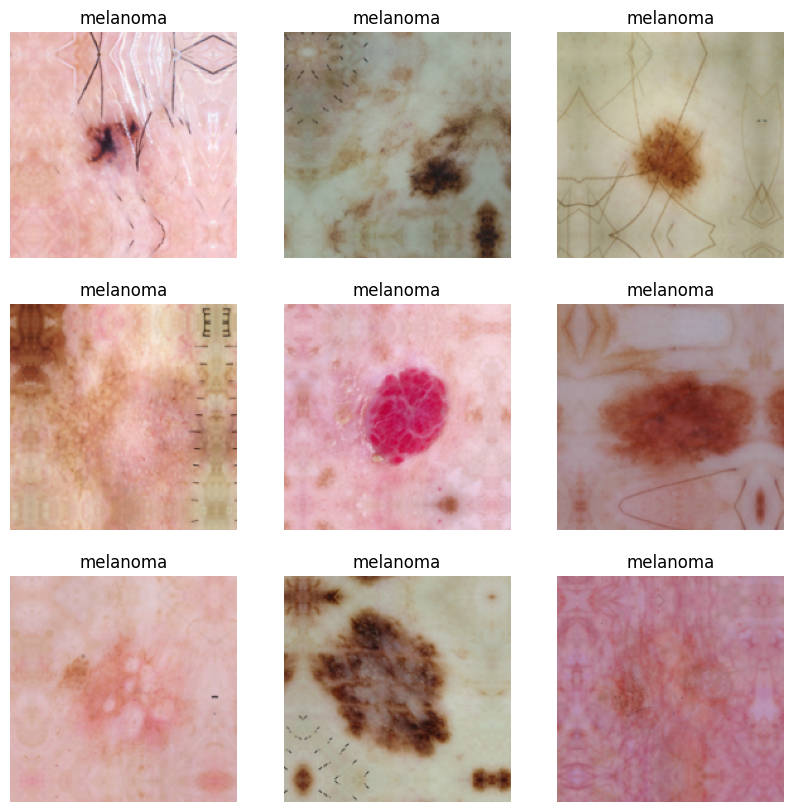

In [18]:
plt.figure(figsize=(10, 10))

for image, label in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augment(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[i].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[1]])
    plt.axis('off')


In [19]:
#RV code
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
"""
model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
"""

#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 5
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [20]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 activation_7 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_5 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 180, 180, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                      

In [22]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/20
56/56 [==============================] - 12s 124ms/step - loss: 5.6471 - accuracy: 0.3064 - val_loss: 5.5412 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 7s 120ms/step - loss: 4.4399 - accuracy: 0.4191 - val_loss: 5.7126 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 7s 119ms/step - loss: 3.7341 - accuracy: 0.4637 - val_loss: 5.3729 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 7s 121ms/step - loss: 3.2077 - accuracy: 0.4760 - val_loss: 5.7004 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 7s 120ms/step - loss: 2.8098 - accuracy: 0.5017 - val_loss: 4.3501 - val_accuracy: 0.0870
Epoch 6/20
56/56 [==============================] - 7s 121ms/step - loss: 2.4833 - accuracy: 0.5061 - val_loss: 4.3196 - val_accuracy: 0.0870
Epoch 7/20
56/56 [==============================] - 7s 120ms/step - loss: 2.2047 - accuracy: 0.5324 - val_loss: 3.8209 - val_accuracy: 0.0870
Epoch

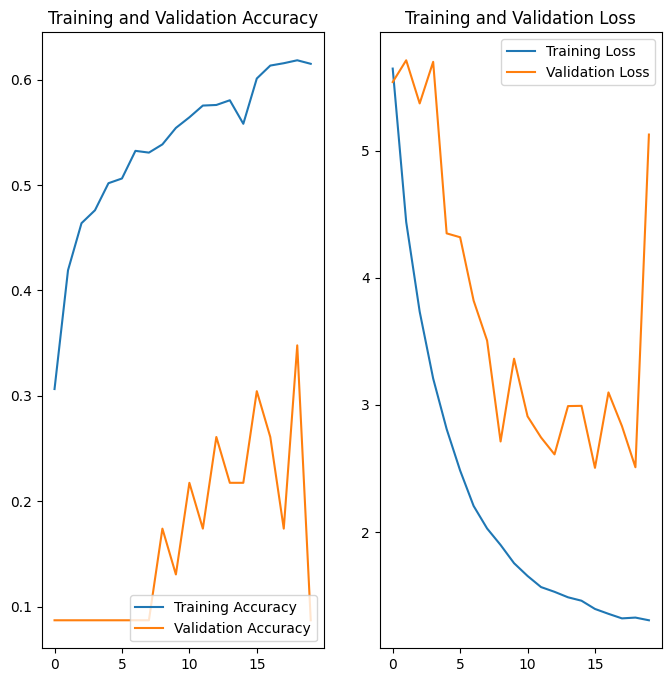

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Performance has fallen. It has worsened. It is still overfitting

Find the distribution of classes in the training dataset.

In [24]:
train_ds_unbatched = tuple(train_ds.unbatch())
labels = []

for images, label in train_ds_unbatched:
  labels.append(label.numpy())

labels = pd.Series(labels)

count_class = labels.value_counts().sort_index()
count_class.index = class_names

print(count_class)

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int64


<Axes: title={'center': 'Class Distribution'}>

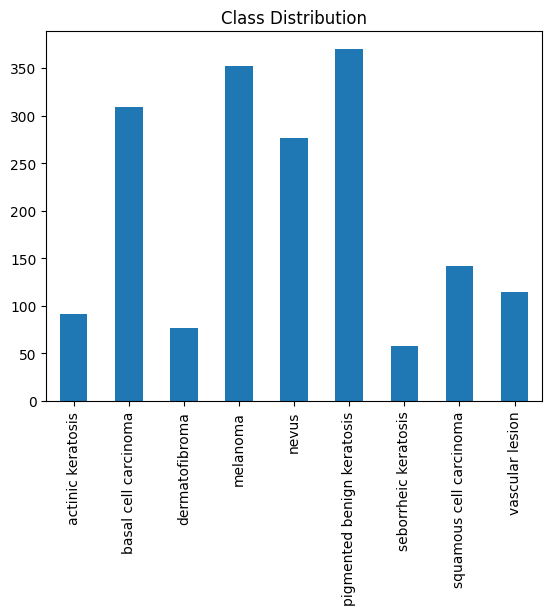

In [25]:
count_class.plot(kind = 'bar', title="Class Distribution")

In [27]:

!pip install Augmentor

In [32]:
path_to_training_dataset= "/content/gdrive/My Drive/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA65A1B0100>: 100%|██████████| 500/500 [00:22<00:00, 22.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA5BACFCF10>: 100%|██████████| 500/500 [00:18<00:00, 26.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA5BAEDAE60>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DA605BEA380>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA65A1B0310>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA5F4B08880>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DA5F4B998A0>: 100%|██████████| 500/500 [00:36<00:00, 13.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DA65A1B1510>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DA5BAD7FEE0>: 100%|██████████| 500/500 [00:16<00:00, 29.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [1]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

NameError: ignored

In [3]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

NameError: ignored

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

**Train the model on the data created using Augmentor**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Create a Training Dataset

In [ ]:
##data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin_cancer/Train/")
data_dir_train = path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Create a Validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Create your Model

In [ ]:
#RV code
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
"""
model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
"""
#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 5
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))